<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Assignment_9/Task_2_with_simple_tuning_Assignment_9_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task:2

## Load Pretrained CNN (e.g., ResNet18)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last few layers
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Replace final FC layer for CIFAR-10 (10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]


## Load CIFAR-10 Dataset (Resized)

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 images
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


## Train

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

num_epochs = 10
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss/len(train_loader):.4f} - Accuracy: {100*correct/total:.2f}%")


Epoch 1/10 - Loss: 0.1319 - Accuracy: 95.66%
Epoch 2/10 - Loss: 0.0389 - Accuracy: 98.98%
Epoch 3/10 - Loss: 0.0187 - Accuracy: 99.58%
Epoch 4/10 - Loss: 0.0221 - Accuracy: 99.31%
Epoch 5/10 - Loss: 0.0170 - Accuracy: 99.51%
Epoch 6/10 - Loss: 0.0150 - Accuracy: 99.56%
Epoch 7/10 - Loss: 0.0168 - Accuracy: 99.48%
Epoch 8/10 - Loss: 0.0083 - Accuracy: 99.77%
Epoch 9/10 - Loss: 0.0159 - Accuracy: 99.50%
Epoch 10/10 - Loss: 0.0103 - Accuracy: 99.69%


## Extract Features

In [5]:
# Remove the final classification layer to use as feature extractor
feature_extractor = nn.Sequential(*list(model.children())[:-1])  # outputs (batch, 512, 1, 1)
feature_extractor.eval()

features = []
labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        feats = feature_extractor(imgs).view(imgs.size(0), -1)  # Flatten
        features.append(feats.cpu())
        labels.append(lbls)

features = torch.cat(features, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()


## Apply PCA or t-SNE

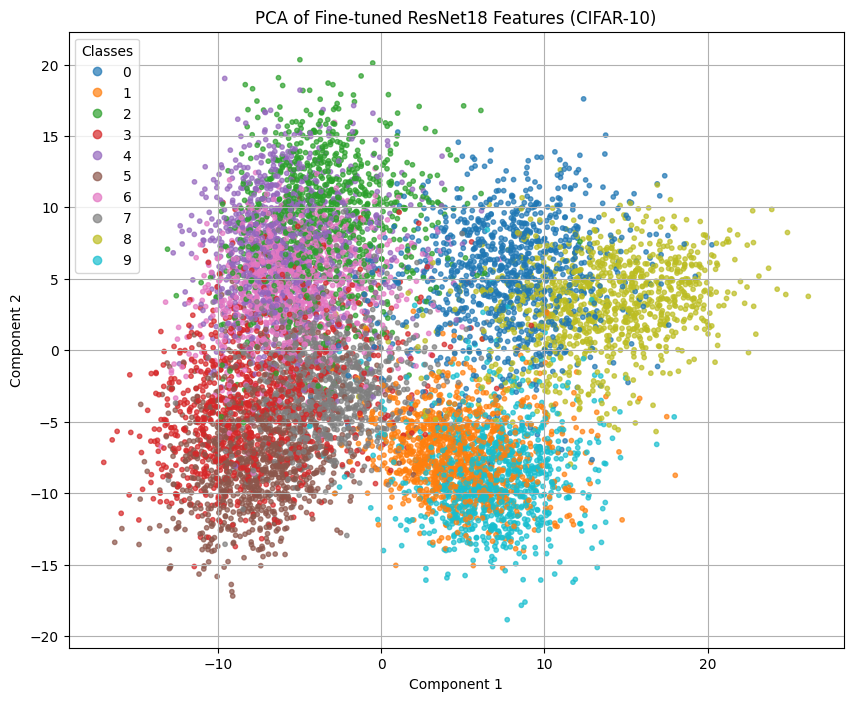

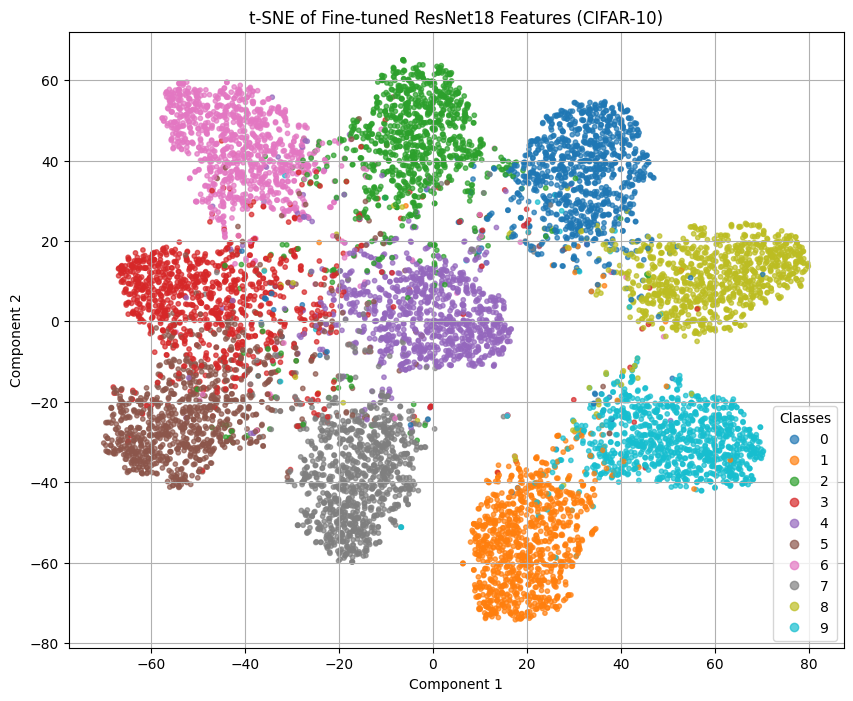

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features)

# Plotting function
def plot_2d(features, labels, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

plot_2d(features_pca, labels, "PCA of Fine-tuned ResNet18 Features (CIFAR-10)")
plot_2d(features_tsne, labels, "t-SNE of Fine-tuned ResNet18 Features (CIFAR-10)")
